# Definitions

In [1]:
# change working directory to the project root
import os
os.chdir('../../')

import sys
sys.path.append('models/utils')
sys.path.append('models/brian2')
sys.path.append('models/aln')

In [2]:
# import python packages
from __future__ import print_function
import os
import datetime
import tqdm
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import scipy 
import pandas as pd
import pypet as pp

# import utils libs
import pypet_parameters as pe
import fitparams as fp
import functions as func
import runModels as rm
import paths

In [3]:
# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = 'plasma'

In [4]:
params = []
params = fp.loadpoint(params, "A2")

params['dt'] = 0.1
params['duration'] =  20000 # 20 seconds
params['sigma_ou'] = 0.0

N_neurons = 10000
params['N'] = N_neurons
params['model'] = 'aln'

# Parameter exploration

In [ ]:
parametrization_aln = pp.cartesian_product({
    'f_sin':[ round(elem, 5) for elem in np.linspace(20.85, 22.85, 41)],
    'A_sin':[ round(elem, 5) for elem in np.linspace(0.001, 0.06, 59)],
    'model':[ 'aln' ],
    'load_point':[ 'A2' ]    
})

parametrization_brian = pp.cartesian_product({
    'f_sin':[ round(elem, 5) for elem in np.linspace(29, 31, 41)],
    'A_sin':[ round(elem, 5) for elem in np.linspace(0.01, 0.2, 59)],
    'model':[ 'brian' ],
    'load_point':[ 'A2' ]    
})

parametrization = parametrization_aln
for k in parametrization:
    parametrization[k].extend(parametrization_brian[k])

In [ ]:
print("Number of parameter configurations: {}".format(len(parametrization[parametrization.keys()[0]])))

In [ ]:
# ---- initialize pypet environment ----
trajectoryName = 'results' + datetime.datetime.now().strftime("-%Y-%m-%d-%HH-%MM-%SS")
HDF_FILE = os.path.join(paths.HDF_DIR, 'phase-entrainment-aln-adex.hdf')
trajectoryFileName = HDF_FILE

import multiprocessing
ncores = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncores))



env = pp.Environment(trajectory=trajectoryName,filename=trajectoryFileName,
                    file_title='phase entrainment',
                    large_overview_tables=True,
                    multiproc=True,           
                    ncores=ncores,
                    wrap_mode='QUEUE',
                    log_stdout = False
                    )

# Get the trajectory from the environment
traj = env.v_trajectory
trajectoryName = traj.v_name

pe.add_parameters(traj, params)

In [ ]:
traj.f_explore(parametrization)
env.f_run(rm.runModels_stimulus)
env.f_disable_logging()
print("Done.")

# Data analysis

## Load results from disk

In [5]:
paths.HDF_DIR = '/mnt/fastio/cakan/hdf-paper-results'

In [6]:
HDF_FILE = os.path.join(paths.HDF_DIR, 'phase-entrainment-aln-adex.hdf')
trajectoryFileName = HDF_FILE

In [7]:
# ---- load pypet trajectory "trajectoryFileName" ----
print("Analyzing File \"{}\"".format(trajectoryFileName))
print("All Trajectories:")
print(pe.getTrajectoryNameInsideFile(trajectoryFileName))
trajectoryName = pe.getTrajectoryNameInsideFile(trajectoryFileName)[-1]

print("Analyzing trajectory \"{}\".".format(trajectoryName))
trajLoaded = pp.Trajectory(trajectoryName,add_time=False)
trajLoaded.f_load(trajectoryName,filename=trajectoryFileName, force=True)
trajLoaded.v_auto_load = True
print("{} results found".format(len(trajLoaded.f_get_results())))

Analyzing File "/mnt/fastio/cakan/hdf-paper-results/phase-entrainment-aln-adex.hdf"
All Trajectories:
[u'results-2019-04-16-05H-13M-48S']
Analyzing trajectory "results-2019-04-16-05H-13M-48S".


No handlers could be found for logger "pypet.storageservice.HDF5StorageService"


4838 results found


In [8]:
nResults = len(trajLoaded.f_get_run_names()) # number of results in trajectory 
dt = trajLoaded.f_get_parameters()['parameters.simulation.dt'].f_get() # dt of simulation

# ---- explored parameter list ----
exploredParameters = trajLoaded.f_get_explored_parameters()
niceParKeys = [p.split('.')[-1] for p in exploredParameters.keys()]

# ---- lcreate pandas df with results as keys ----
dfResults = pd.DataFrame(columns=niceParKeys,dtype=object)

# range of parameters
for nicep, p in zip(niceParKeys,exploredParameters.keys()):
    dfResults[nicep] = exploredParameters[p].f_get_range()
    
# ---- make a dictionary with results ----
resultDicts = []
print("Creating results dictionary ...")
runResults = []
for rInd in tqdm.tqdm(range(len(dfResults)), total=len(dfResults)):
    result = trajLoaded.results[rInd].f_to_dict()
    result['model'] = dfResults.iloc[rInd]['model']
    runResults.append(result)
print("done.")    

  0%|          | 4/4838 [00:00<02:02, 39.31it/s]

Creating results dictionary ...


100%|██████████| 4838/4838 [01:47<00:00, 44.81it/s]

done.


## Analysis functions

In [40]:
def kuramoto(traces, smoothing=0.0, dt = 0.1, debug = False, peakrange=[0.1, 0.2]):
    phases = []
    nTraces = len(traces)
    for n in range(nTraces):
        tList = np.dot(range(len(traces[n])),dt/1000)
        a = traces[n]
        
        # find peaks
        if smoothing > 0:
            a = scipy.ndimage.filters.gaussian_filter(traces[n], smoothing) # smooth data
        maximalist = scipy.signal.find_peaks_cwt(a, np.arange(peakrange[0], peakrange[1]))
        maximalist = np.append(maximalist, len(traces[n])-1).astype(int)
        
        if len(maximalist) > 1:
            #for m in maximalist:
                #plt.scatter(m, a[m] , c='C{}'.format(n), zorder = 20, s=10.5)

            phases.append([])
            lastMax = 0
            for m in maximalist:
                #print(lastMax, m)
                for t in range(lastMax, m):
                    phi = 2 * np.pi * float(t - lastMax) / float(m - lastMax)
                    phases[n].append(phi)
                lastMax = m
            phases[n].append(2 * np.pi)
            #plt.plot(phases[n], c='C{}'.format(n),)
        else:
            return 0
    
    # determine kuramoto order paramter
    kuramoto = []
    for t in range(len(tList)):
        R = 1j*0
        for n in range(nTraces):
            R += np.exp(1j * phases[n][t])
        R /= nTraces
        kuramoto.append(np.absolute(R))
    
    
    #plt.plot(kuramoto, c='g')
    #plt.show()   
    return kuramoto
    
#kuramoto(traces, 5)

In [110]:
def analyse_run(measure = 'domfr', result = []):
    t = result['t']
    rate = result['rate_exc']
    stimulus = result['stimulus']
    model = result['model']
    
    # subsample data
    if model == 'brian':
        traces = [rate[::10], stimulus[::10]]
    else:
        traces = [rate[::10], stimulus[::10]] 
    
    if measure == 'mean_kuramoto':
        if model == 'brian':
            kur = kuramoto(traces, smoothing=5.0)
        else:
            kur = kuramoto(traces, smoothing=5.0)
        kur_analyze = kur[5000:-500]
        meankur = np.mean(kur_analyze)
        stdkur = np.std(kur_analyze)
        return meankur
        
    if measure == 'std_kuramoto':
        if model == 'brian':
            kur = kuramoto(traces, smoothing=5.0)
        else:
            kur = kuramoto(traces, smoothing=5.0)
        kur_analyze = kur[5000:-500]        
        meankur = np.mean(kur_analyze)
        stdkur = np.std(kur_analyze)
        return stdkur
    
    if measure == 'plot':
        traces = [traces[0][100:], traces[1][100:]]
        bis = len(stimulus)
        
        min_len = np.min([len(traces[0]), len(traces[1])])
        traces = [traces[0][:min_len], traces[1][:min_len]]
        # traces and stimulus plot
        tlist_r = np.multiply(range(len(traces[0])),0.001)
        tlist_s = np.multiply(range(len(traces[1])),0.001)
        
        f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 2.0), dpi=300)
        #plt.figure(figsize=(4, 1.0), dpi=300)
        axs[0].plot(tlist_r, (traces[0]-np.mean(traces[0]))/np.std(traces[0]), lw=0.5, c='k')
        axs[0].plot(tlist_s, (traces[1]-np.mean(traces[1]))/np.std(traces[1]), lw=0.5, c='C3', alpha=0.5, label = 'Input')
        axs[0].set_yticks([])
        axs[0].set_xticks([0, 20])
        
        #ax = plt.gca()
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)
        axs[0].spines['left'].set_visible(False)
        axs[0].tick_params(direction='out', length=6, width=1, colors='k', labelsize=8)
        axs[0].set_ylabel("Rate", fontsize=10, color='k')
        
        #plt.show()
        
        # KURAMOTO PLOT
        kur = kuramoto(traces, smoothing=5)
        
        tlist_k = np.multiply(range(len(kur)),0.001)
        #plt.figure(figsize=(3.7, 0.7), dpi=300)
        #axk = plt.gca()
        axs[1].plot(tlist_k[1100:-500], kur[1100:-500], c='k', lw=1.0, label = 'R')
        axs[1].set_yticks([0, 1])
        
        axs[1].set_xticks([0, 20])
        axs[1].set_ylim(-0.1, 1.1)

        axs[1].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['bottom'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        axs[1].tick_params(direction='out', length=6, width=1, colors='k', labelsize=8)
        axs[1].set_ylabel("R", fontsize=10, color='k')
        axs[1].set_xlabel("Time [s]", fontsize=10, color='k')
        
        plt.show()
    if measure == 'zoomplot':
        traces = [traces[0][100:], traces[1][100:]]
        bis = len(stimulus)
        
        min_len = np.min([len(traces[0]), len(traces[1])])
        traces = [traces[0][:min_len], traces[1][:min_len]]
        # traces and stimulus plot
        tlist_r = np.multiply(range(len(traces[0])),0.001)
        tlist_s = np.multiply(range(len(traces[1])),0.001)
        
        #f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 2.0), dpi=300)
        #fig = plt.figure(figsize=(3.65, 0.8), dpi=300) # same size as large plot
        fig = plt.figure(figsize=(1.5, 0.8), dpi=300)
        plt.plot(tlist_r, (traces[0]-np.mean(traces[0]))/np.std(traces[0]), lw=1.0, c='k')
        plt.plot(tlist_s, (traces[1]-np.mean(traces[1]))/np.std(traces[1]), lw=1.0, c='C3', alpha=0.8, label = 'Input')
        plt.yticks([])
        
        
        ax = plt.gca()
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        ax.tick_params(direction='out', length=6, width=1, colors='k', labelsize=8)
        
        #plt.show()
        #plt.xlabel("Time [s]", fontsize=10, color='k')
        fr, to = 15, 16
        plt.xlim(fr, to)
        plt.xticks([fr, to])
        plt.xticks([])
        plt.show()

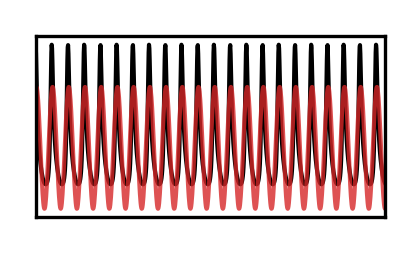

In [111]:
analyse_run(measure='zoomplot', result=runResults[806])

## Parallel processing

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()   

In [ ]:
for measure in ['mean_kuramoto', 'std_kuramoto']:
    print("Analysing measure: {}".format(measure))
    parallelResults = Parallel(n_jobs=num_cores)(delayed(analyse_run)(measure = measure, result = i) for i in tqdm.tqdm(runResults))
    dfResults[measure] = parallelResults
print("done.")

## Serial Processing

In [ ]:
# ---- make a dictionary with results ----
resultDicts = []

#measures = ['domfr_exc', 'domfr_power_exc', 'max_exc', 'min_exc', 'updowndiff_exc', 'domfr_inh','domfr_power_inh', 'max_inh', 'min_inh', 'updowndiff_inh'] 
measures = ['std_kuramoto']

for rInd in tqdm.tqdm(range(nResults), total=nResults):
    print(rInd)
    for measure in measures:
        dfResults.loc[rInd, measure] = analyse_run(measure, runResults[rInd])    
print("done.")

In [20]:
paths.PICKLE_DIR = "/mnt/fastio/cakan/pickle-paper-results"

In [21]:
import pickle

file_path_p = os.path.join(paths.PICKLE_DIR, 'phase-entrainment-aln-adex-dfResults.p')
# uncomment to save results
#pickle.dump(dfResults, file(file_path_p, "w"))

# load precomputed results
dfResults = pickle.load(file(file_path_p, "r"))

In [22]:
# hotfix: amplitudes in hdf are peak-to-peak, convert to zero-to-peak
dfResults.A_sin = dfResults.A_sin / 2

In [23]:
dfResults

,f_sin,load_point,A_sin,model,mean_kuramoto,std_kuramoto
0,20.85,A2,0.000500,aln,0.636490,0.304582
1,20.85,A2,0.001010,aln,0.634618,0.309414
2,20.85,A2,0.001515,aln,0.638507,0.306235
3,20.85,A2,0.002025,aln,0.636415,0.311224
4,20.85,A2,0.002535,aln,0.635494,0.316036
5,20.85,A2,0.003045,aln,0.648965,0.299470
6,20.85,A2,0.003550,aln,0.638737,0.317440
7,20.85,A2,0.004060,aln,0.650563,0.301863
8,20.85,A2,0.004570,aln,0.643924,0.315742
9,20.85,A2,0.005080,aln,0.659012,0.297138


dfResults

In [24]:
import aEIF_extended as IF_Models
EIFNeuron = IF_Models.EIFModel()

# DEFAULT VALUES
# check if BS parameters C and gL match with the AdEx parameters
print("aEIF C: {}".format(params['C']*1e-12))
print("aEIF gL: {}".format(params['gL']*1e-9))

#EIFNeuron.C_soma     = 1.0e-2  # Soma membrane capacitance (F / m2)
#EIFNeuron.rhom_soma  = 28.0e-1  # Soma membrane resistivity (Ohm m2)
#EIFNeuron.d_soma     = 10e-6   # Soma diameter ( m )

EIFNeuron.d_dend      = 2.0e-6  # Dendritic tree diameter (m)
EIFNeuron.L           = 1200.0e-6  # Dendritic tree length (m)

EIFNeuron.updateParams()

print("BS C: {}".format(EIFNeuron.C_s))
print("BS gL: {}".format(EIFNeuron.gL))

def current_for_adex(freq, EIFNeuron):
    # impedance
    z_adex = params['gL']*1e-9 * (1-1 * np.exp((-65-params['VT'])/params['DeltaT'])) + params['C']*1e-12 * 1j* 2*np.pi * freq
    z_bs = EIFNeuron.gL * (1 - 1 * np.exp((-65e-3-EIFNeuron.VT)/EIFNeuron.deltaT)) +  EIFNeuron.C_s * 1j* 2*np.pi * freq

    current = z_adex * EIFNeuron.polarizationTransfer(freq)
    return np.abs(current)

freq = 30
print("{} pA".format(current_for_adex(freq, EIFNeuron)*1e12))

aEIF C: 2e-10
aEIF gL: 1e-08
BS C: 3.14159265359e-12
BS gL: 1.12199737628e-10
15.7509473706 pA


# Plot

In [28]:
A_sin_range[0]*200

0.0050000000000000001

In [31]:
A_sin_range[-1]*200

20.0

aln: A2
Saving phase-entrainment-aln-A2-mean-kuramoto


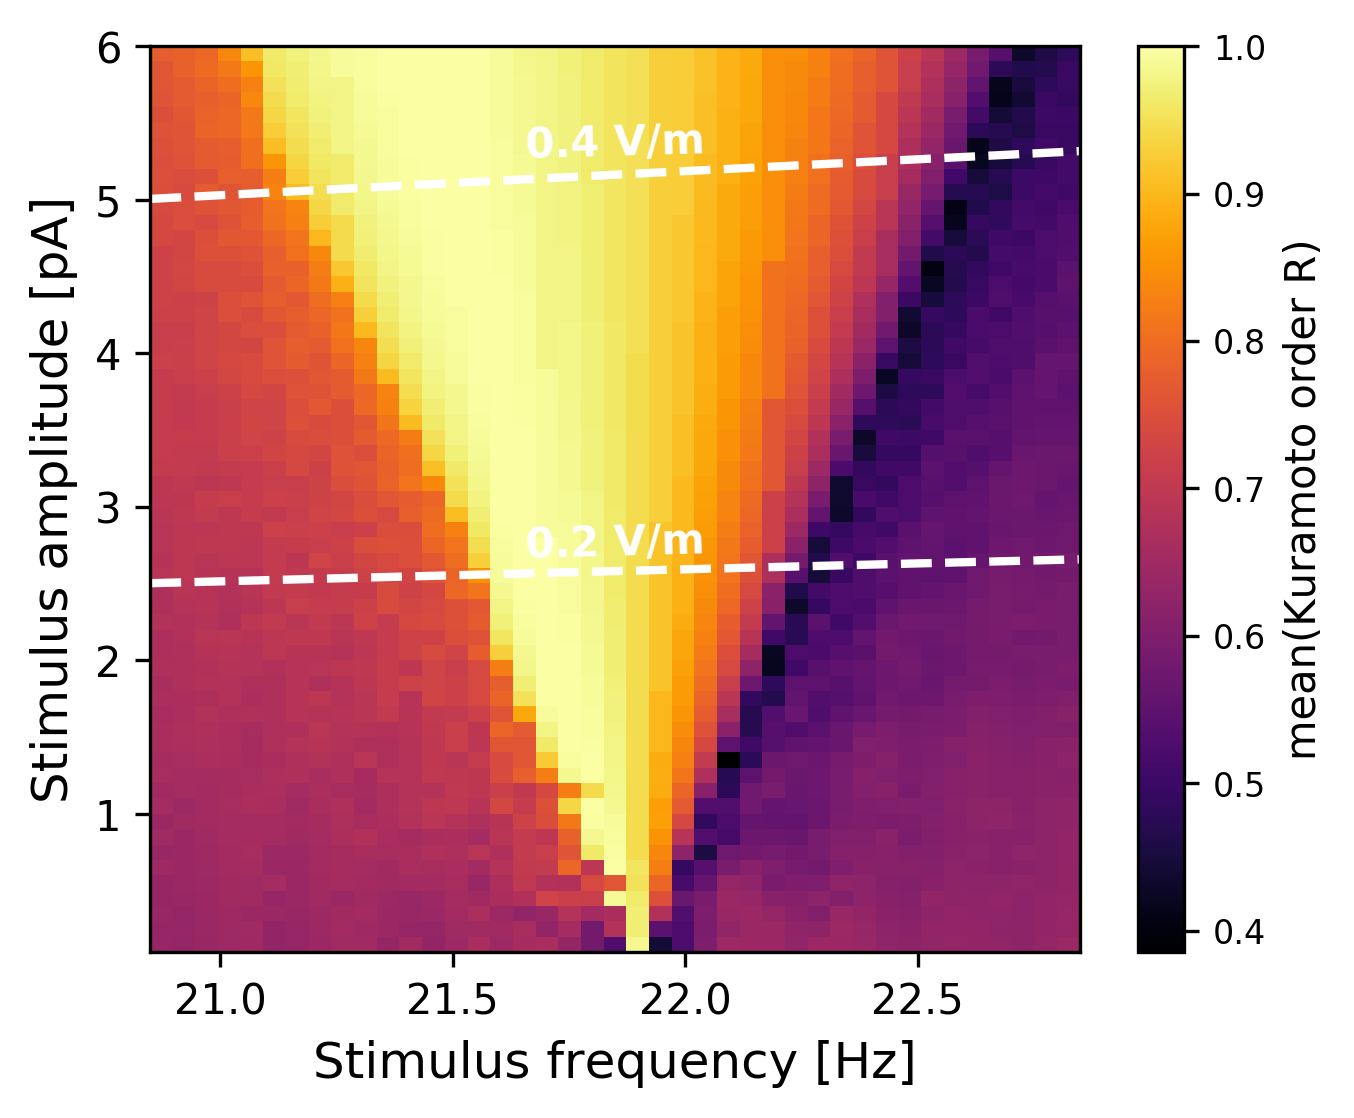

Saving phase-entrainment-aln-A2-std-kuramoto


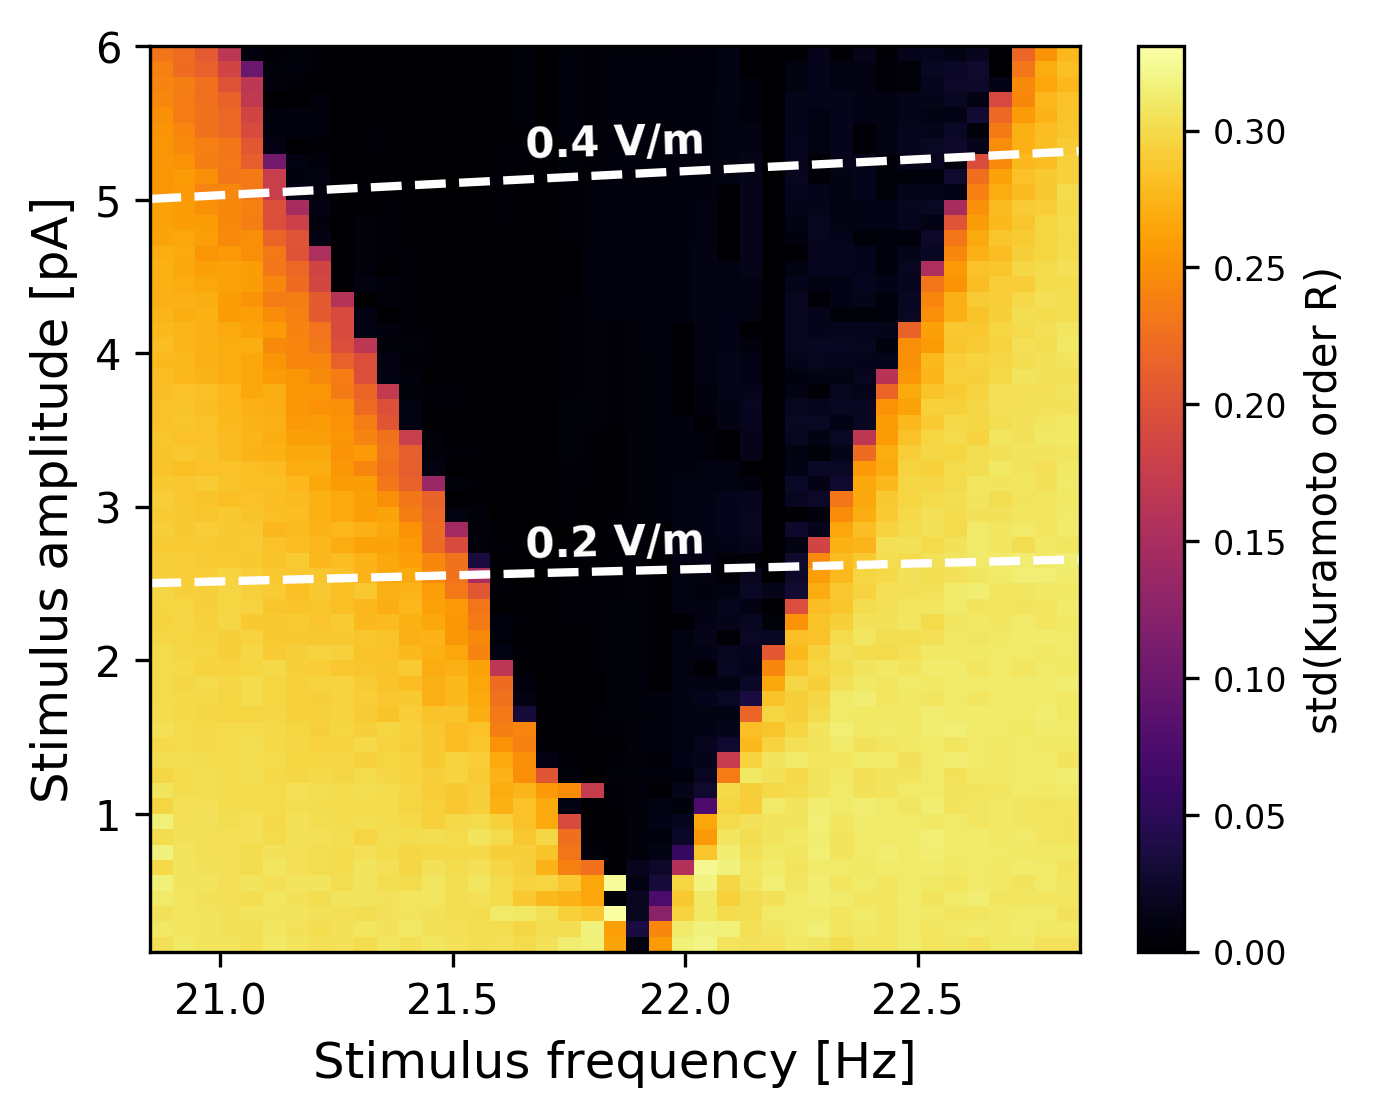

brian: A2
Saving phase-entrainment-brian-A2-mean-kuramoto


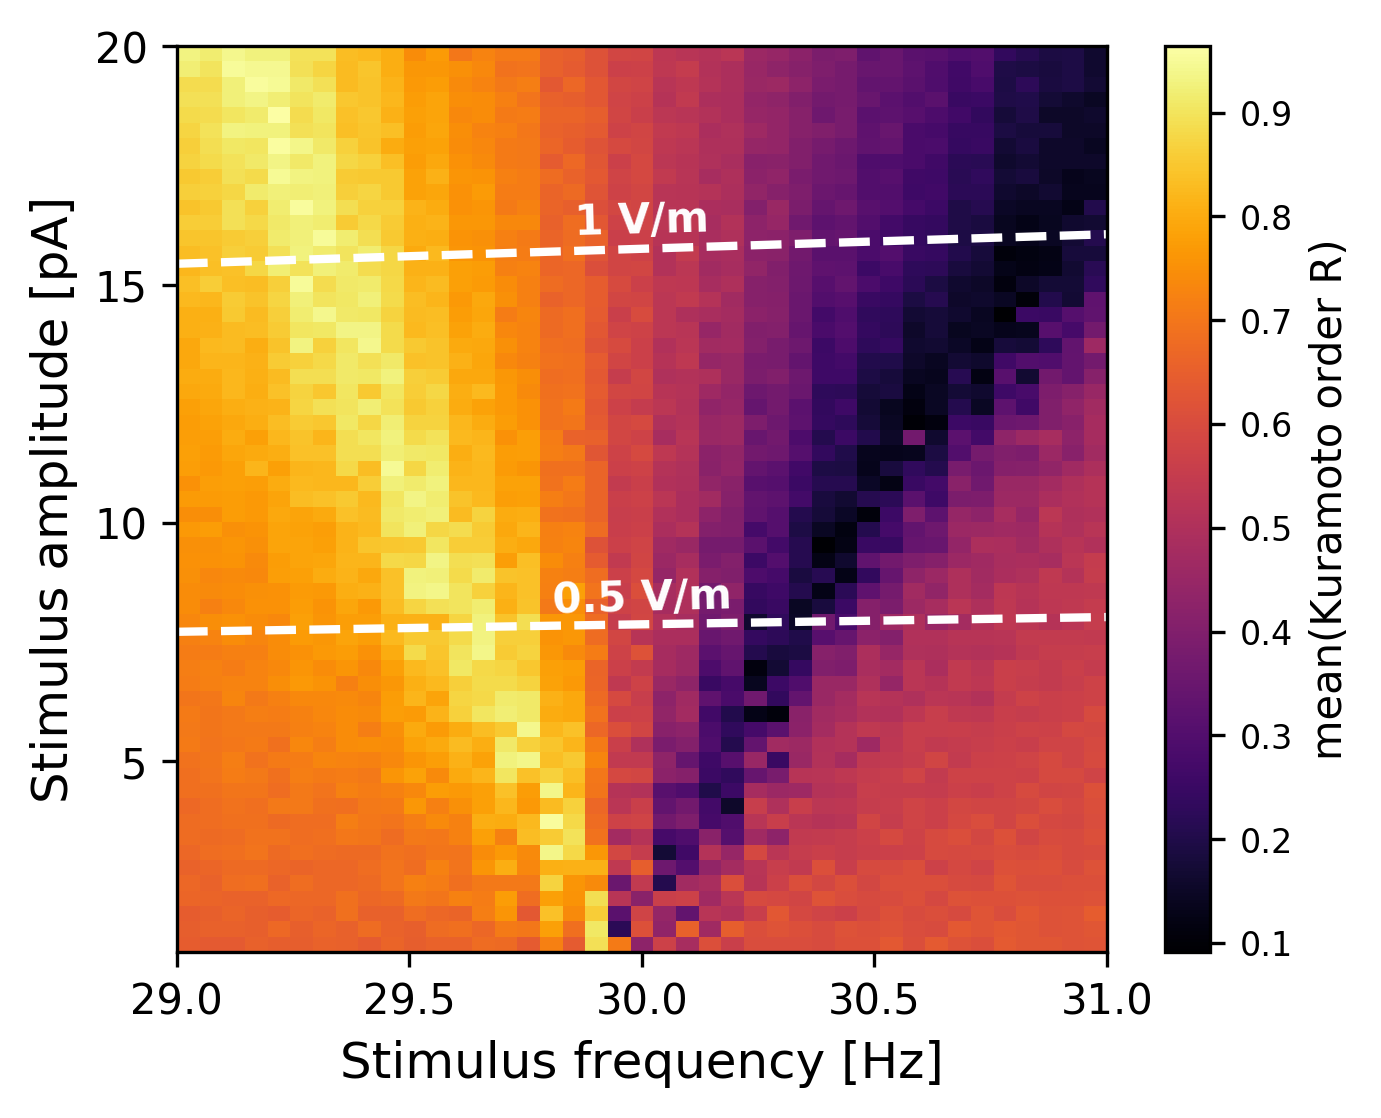

Saving phase-entrainment-brian-A2-std-kuramoto


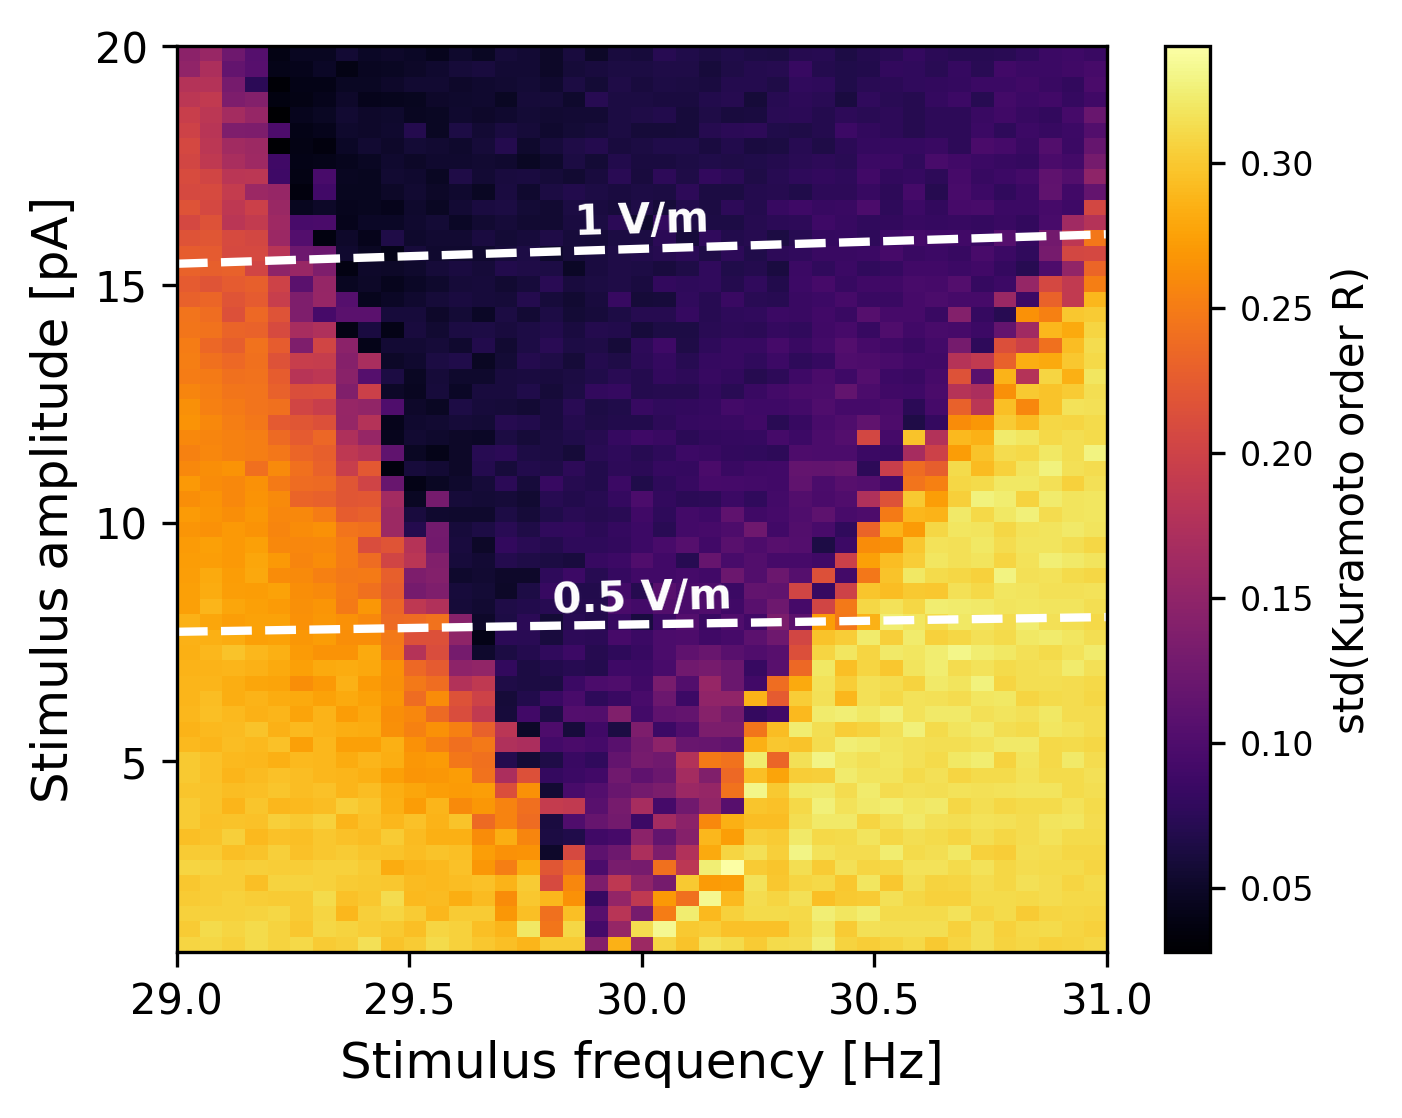

In [115]:
models = np.unique(dfResults['model'])  
points = np.unique(dfResults['load_point'])  

for model in models:
    for point in points:
        print("{}: {}".format(model, point))
        mean_kurs = []
        std_kurs = []
        
        selector = (dfResults.model==model) & (dfResults.load_point==point)
        selectedResults = dfResults[selector]
        selectIndices = selectedResults.index
        
        for i in range(len(selectedResults)):
            mean_kurs.append(selectedResults.iloc[i]['mean_kuramoto'])
            std_kurs.append(selectedResults.iloc[i]['std_kuramoto'])


        freqs = np.unique(selectedResults['f_sin'])  
        amps = np.unique(selectedResults['A_sin'])    


        kuramoto_matrix = np.reshape(mean_kurs, (len(freqs), len(amps))).T
        std_kuramoto_matrix = np.reshape(std_kurs, (len(freqs), len(amps))).T
        
        for with_field_amp in [True]: # draw lines with field amplitudes, yes and no

            for matrix, label, simple_label in zip([kuramoto_matrix, std_kuramoto_matrix], ['mean(Kuramoto order R)', 'std(Kuramoto order R)'], ['mean', 'std']):
                f_sin_range = freqs
                A_sin_range = amps



                plt.figure(figsize=(5, 4), dpi=300)
                plt.imshow(matrix, cmap='inferno', origin='lower', aspect='auto', extent=[f_sin_range[0],
                                                                                                   f_sin_range[-1],
                                                                                                   A_sin_range[0]*200,
                                                                                                   A_sin_range[-1]*200])
                cbar = plt.colorbar(label=label)
                #cbar = plt.colorbar().set_label(label=label,size=12)
                cbar.ax.tick_params(labelsize=8) 

                xticknum = 5
                if model == 'aln':
                    yticknum = 6
                elif model == 'adex':
                    yticknum = 4
                plt.locator_params(axis='y', nbins=yticknum)
                plt.xlabel('Stimulus frequency [Hz]', fontsize=12)
                plt.ylabel('Stimulus amplitude [pA]', fontsize=12)
                if with_field_amp:
                    efield_amps = [current_for_adex(f, EIFNeuron) for f in np.linspace(f_sin_range[0], f_sin_range[-1], 10)]
                    efield_amps = np.multiply(efield_amps, 1e12)

                    fields = [0.2, 0.4]
                    if model == 'brian':
                        fields = [0.5, 1]

                    for vm in fields:
                        plt.plot( np.linspace(f_sin_range[0], f_sin_range[-1], 10), np.multiply(efield_amps, vm), lw=2, c='white', ls='--')
                        plt.text(f_sin_range[0]+(f_sin_range[-1]-f_sin_range[0])/2, efield_amps[6]*vm, '{} V/m'.format(vm), color='white', weight="bold", rotation=1.5, ha='center', va='bottom')

                if with_field_amp:
                    fname = 'phase-entrainment-{}-{}-{}-kuramoto'.format(model, point, simple_label)
                    print("Saving {}".format(fname))
                    for extension in ['png', 'svg', 'jpg']:
                        plt.savefig(os.path.join(paths.FIGURES_DIR, "{}.{}".format(fname, extension)))

                plt.show()



## Plot traces

f_sin                  21.5
load_point               A2
A_sin              0.020335
model                   aln
mean_kuramoto      0.994681
std_kuramoto     0.00197754
Name: 806, dtype: object


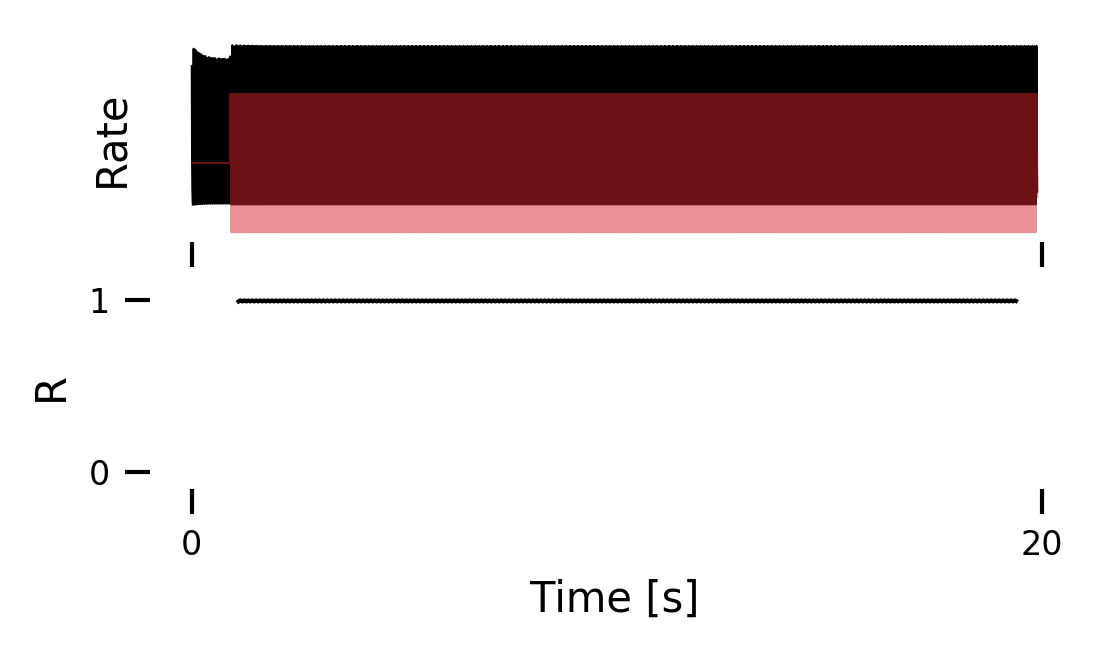

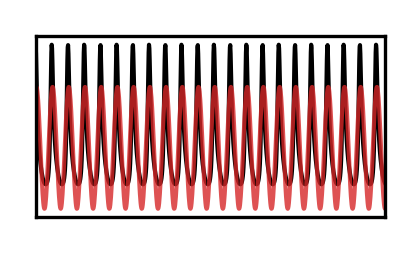

f_sin               22.45
load_point             A2
A_sin            0.012705
model                 aln
mean_kuramoto    0.546944
std_kuramoto     0.299486
Name: 1912, dtype: object


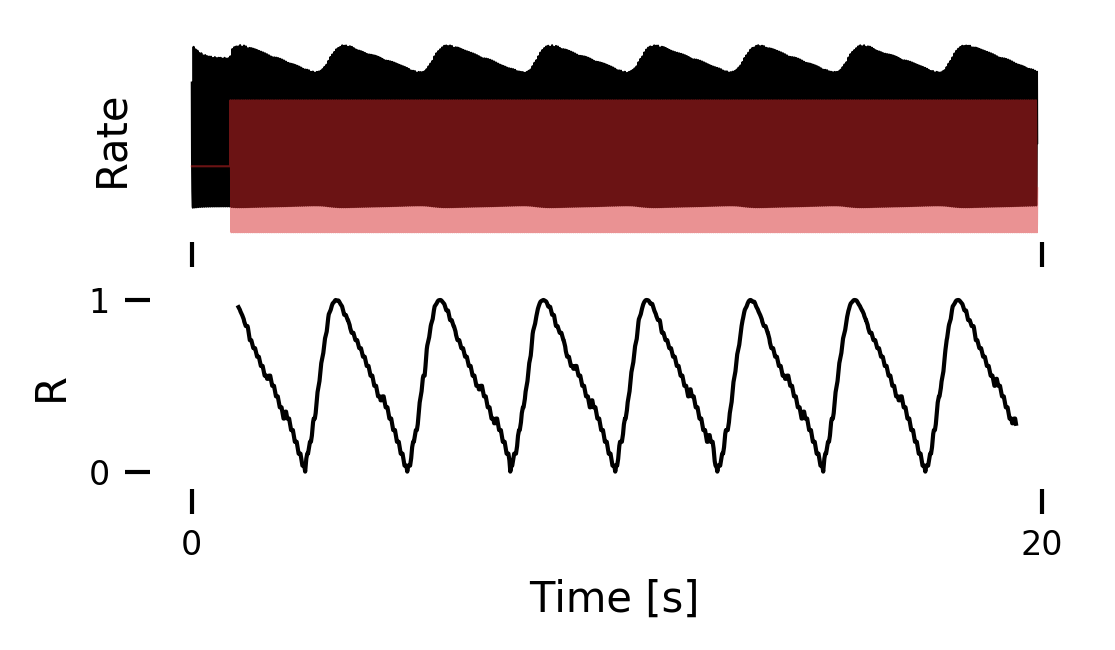

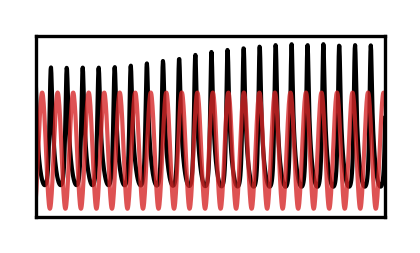

f_sin                22.4
load_point             A2
A_sin            0.016775
model                 aln
mean_kuramoto     0.45128
std_kuramoto       0.2229
Name: 1861, dtype: object


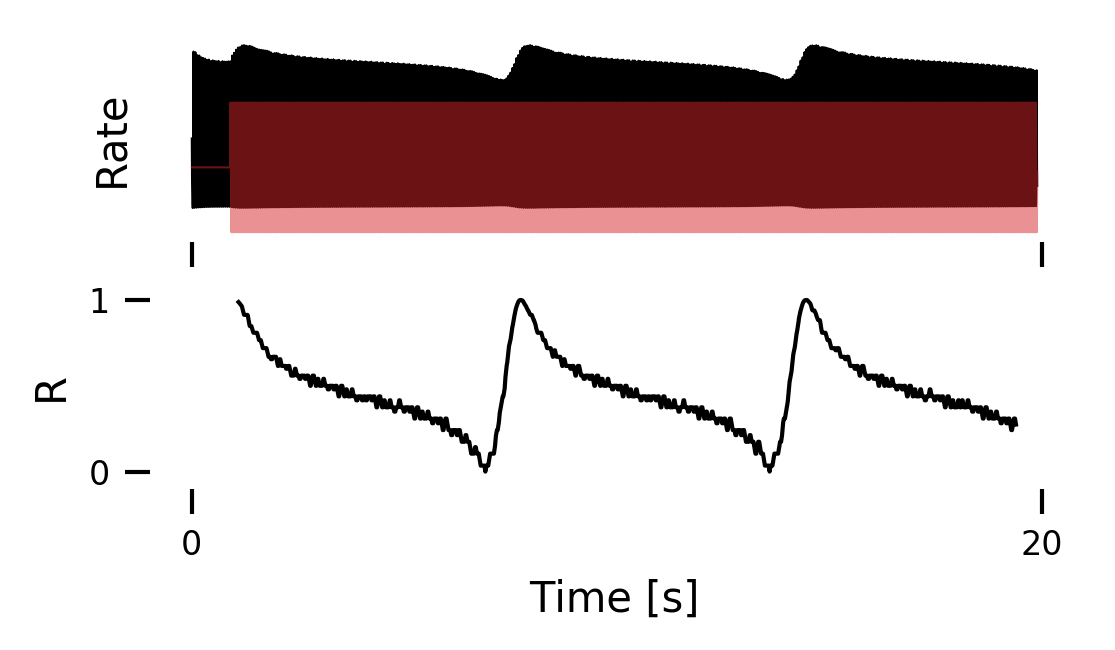

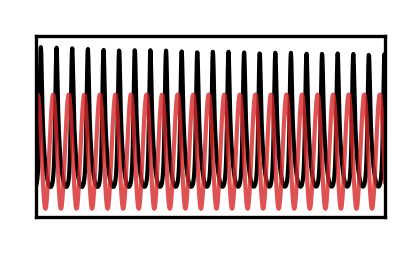

f_sin               21.55
load_point             A2
A_sin              0.0122
model                 aln
mean_kuramoto    0.812571
std_kuramoto     0.204249
Name: 849, dtype: object


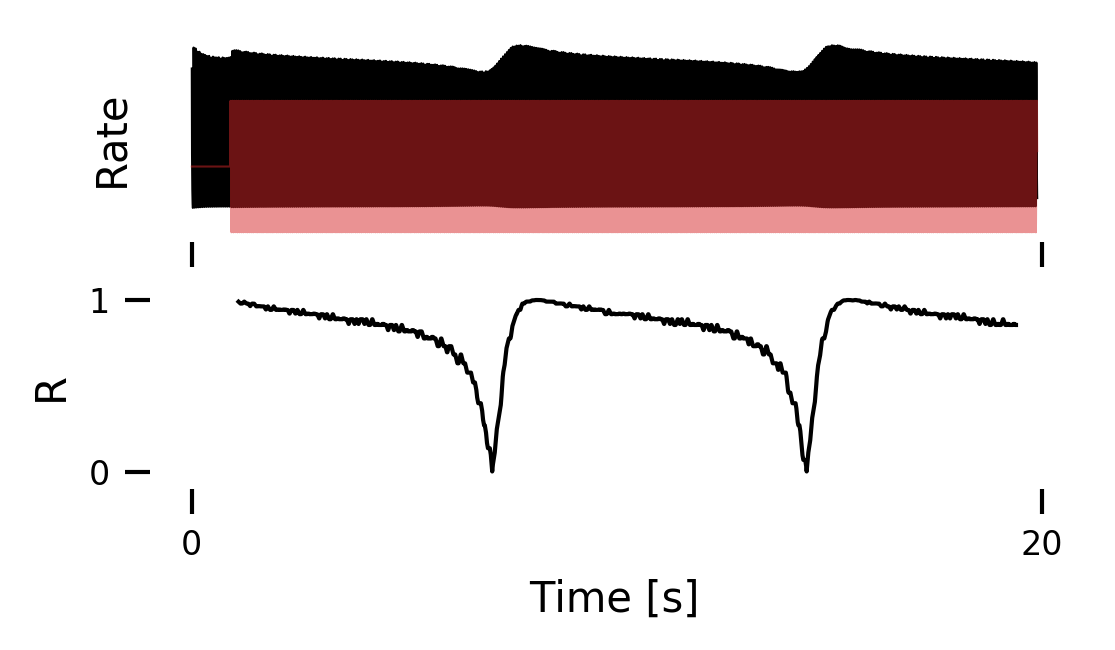

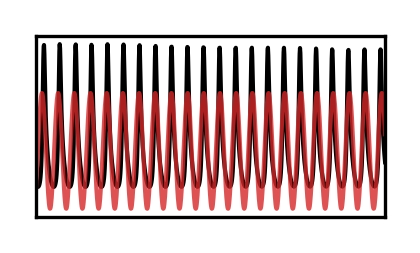

In [114]:
# aln: 1: 806, 2: 1912, 3: 1861, 4: 849
plotpoints = [806, 1912, 1861, 849]
for p in plotpoints:
    print(dfResults.iloc[p])
    analyse_run(measure='plot', result=runResults[p])
    analyse_run(measure='zoomplot', result=runResults[p])

f_sin                29.55
load_point              A2
A_sin             0.078705
model                brian
mean_kuramoto     0.827079
std_kuramoto     0.0537425
Name: 3113, dtype: object


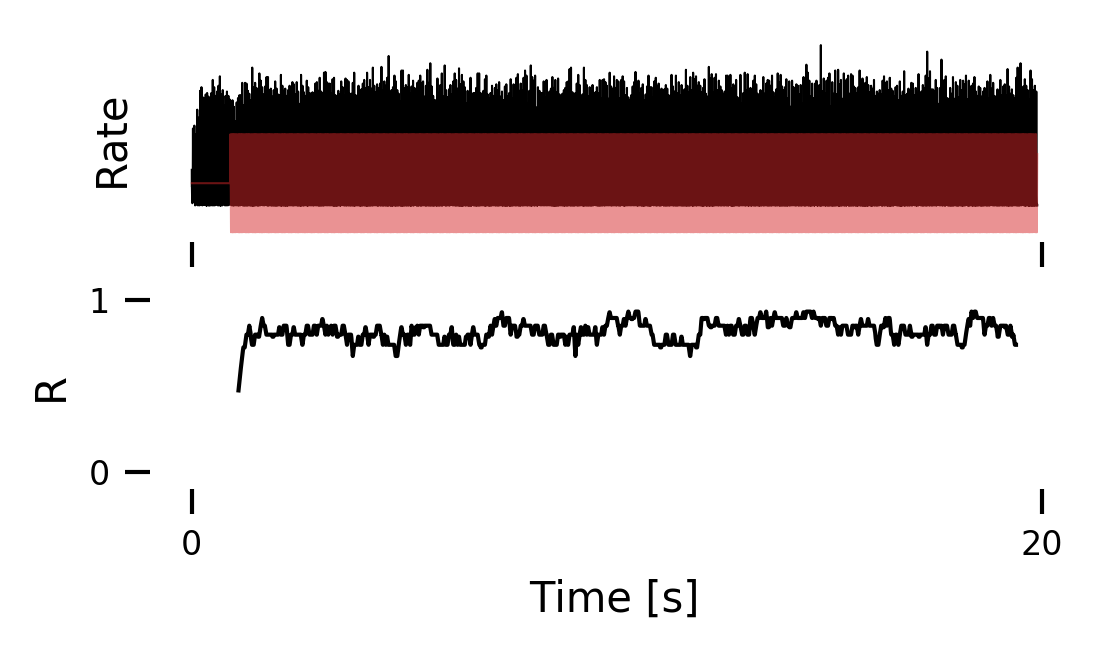

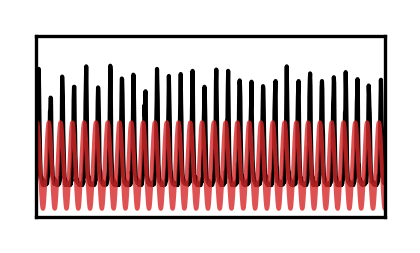

f_sin                30.6
load_point             A2
A_sin             0.02957
model               brian
mean_kuramoto    0.532026
std_kuramoto     0.316113
Name: 4322, dtype: object


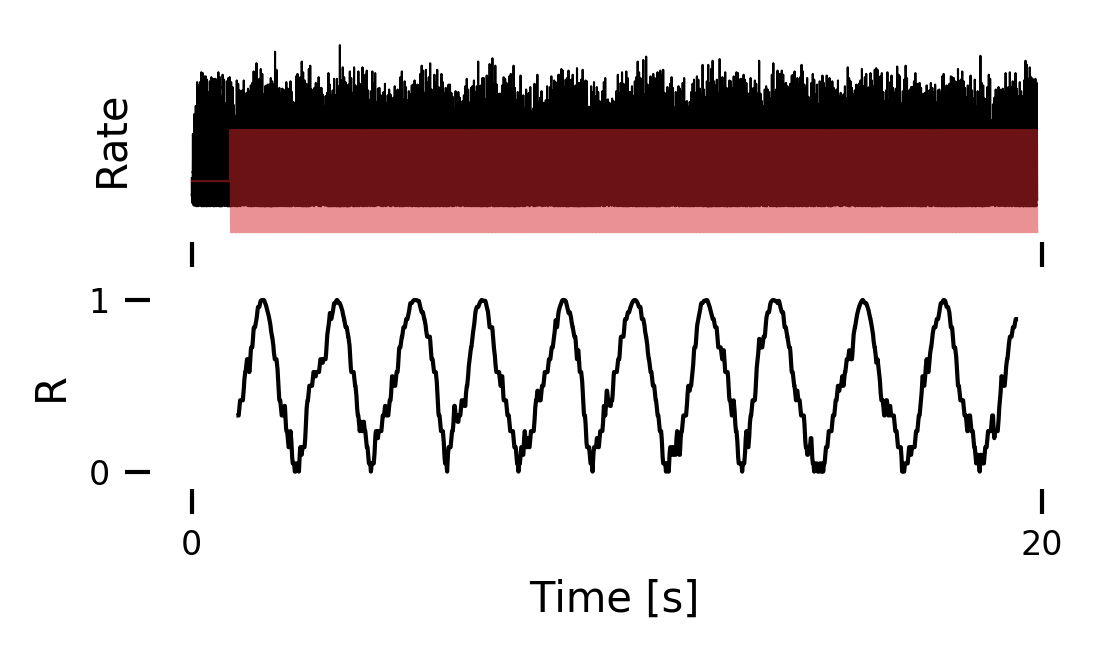

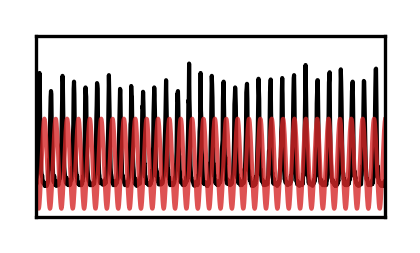

f_sin                30.7
load_point             A2
A_sin             0.06233
model               brian
mean_kuramoto    0.208874
std_kuramoto     0.229278
Name: 4460, dtype: object


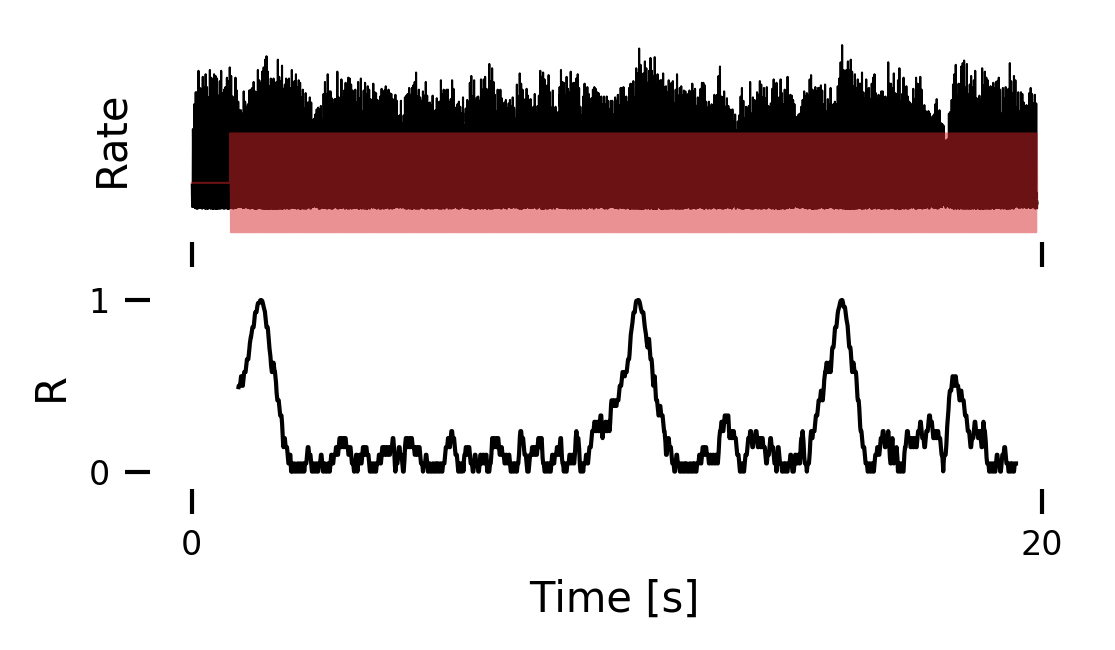

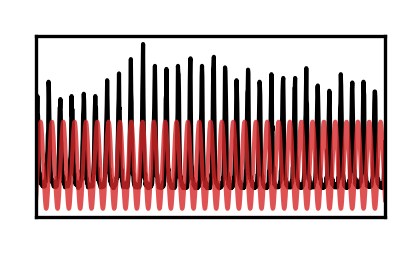

f_sin               29.65
load_point             A2
A_sin            0.031205
model               brian
mean_kuramoto     0.88009
std_kuramoto     0.200027
Name: 3202, dtype: object


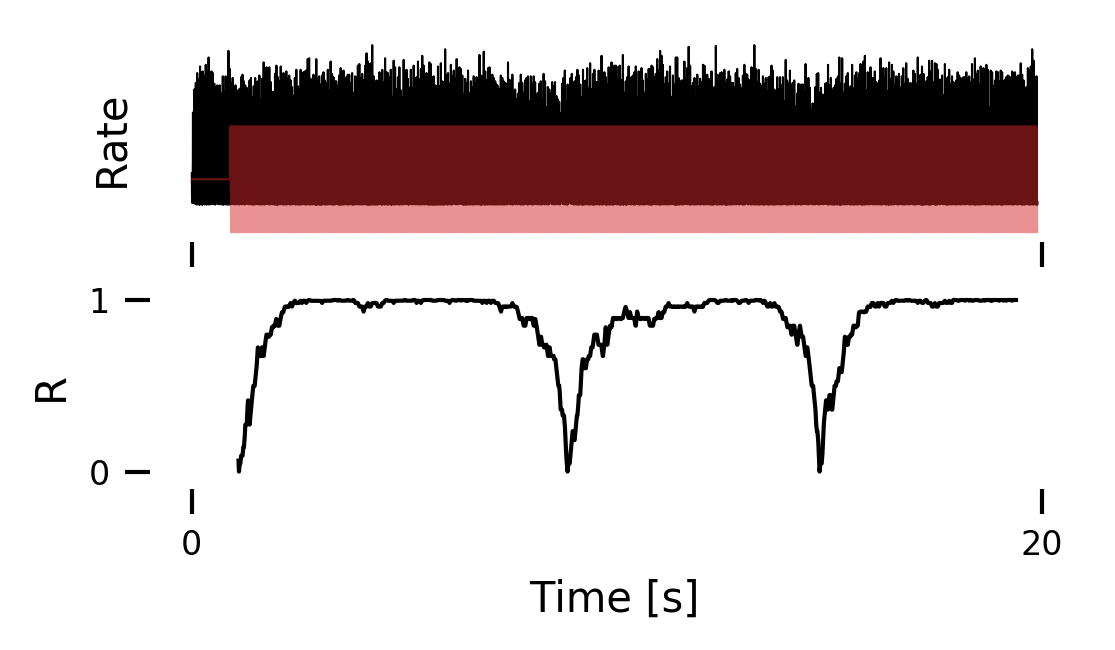

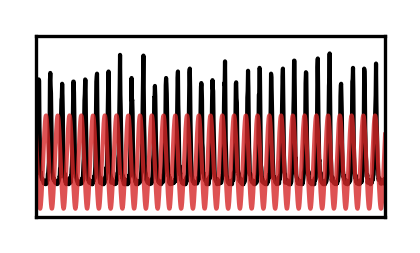

In [113]:
# adex, 1: 3113, 2: 4322, 3: 4460, 4:3202
plotpoints = [3113, 4322, 4460, 3202]
for p in plotpoints:
    print(dfResults.iloc[p])
    analyse_run(measure='plot', result=runResults[p])
    analyse_run(measure='zoomplot', result=runResults[p])

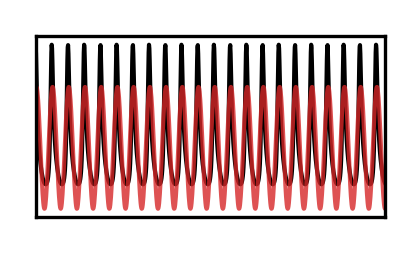

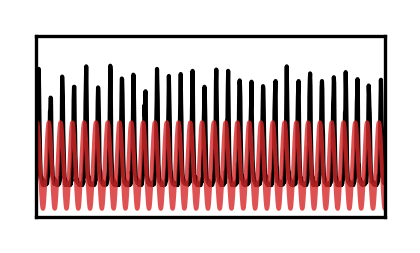

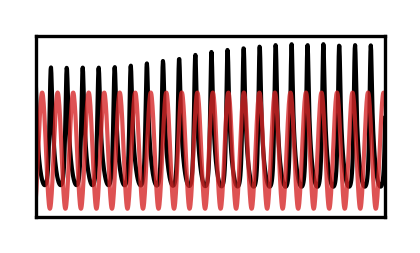

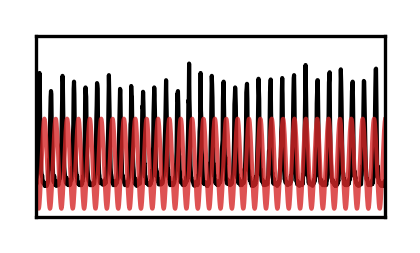

In [112]:
plotpoints = [806, 3113, 1912, 4322]
for p in plotpoints:
    analyse_run(measure='zoomplot', result=runResults[p])